In [15]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPA1")
results_dir.mkdir(parents=True, exist_ok=True)

NameError: name 'np' is not defined

 Load input RNA allelic counts. 

In [16]:
basedir = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/allelic/"
input_files = [ basedir + "input-rep1_allelic.out" ]

IP_files = [ basedir + "hnrnpa1-rep1_allelic.out" ]

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]
input_counts[0].head()

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,26,0,26
1,chr1,16141,rs529651976,C,T,52,2,54
2,chr1,16280,.,T,C,29,0,29
3,chr1,128747,rs565117739,A,C,10,1,11
4,chr1,137978,rs529853750,G,A,520,1,521


Observed genotype data (after running StrandScript)

In [17]:
geno = io_utils.loadGenotypes('/gpfs/commons/home/phalmos/genotypes/CIRMlines_flipped.vcf', 
                     maxlines = None, 
                     posterior = False).rename(columns = {"SNP" : "variantID"})
geno.head()

,position,contig,variantID,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
rs3131972,752721,chr1,rs3131972,G,A,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
rs11240777,798959,chr1,rs11240777,G,A,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
rs4970383,838555,chr1,rs4970383,N,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs4475691,846808,chr1,rs4475691,C,T,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.0
rs13302982,861808,chr1,rs13302982,G,A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


# Deconvolution

sum(w)=1.001391 ideally would be 1


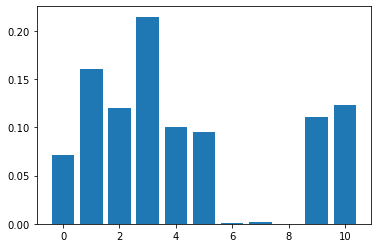

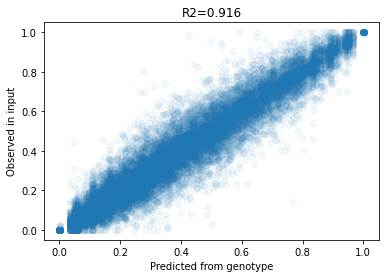

In [18]:
w = [ deconvolve.deconvolve(geno, inp) for inp in input_counts ]

In [19]:
props = pd.DataFrame(w).transpose()
props.columns = ["rep1"]
props["line"] = geno.columns[5:16]
props.iloc[:,[0,1]].to_csv(results_dir / "deconv.tsv", index = False, sep = "\t")

props

,rep1,line
0,0.071627,CW30274-1-1194512543_CW30274-1-1194512543
1,0.160709,CW30454-1-1194512472_CW30454-1-1194512472
2,0.120467,CW30421-1-1194512512_CW30421-1-1194512512
3,0.214985,CW70372-1-1194512488_CW70372-1-1194512488
4,0.100975,CW40201-1-1194512480_CW40201-1-1194512480
5,0.094822,CW30525-1-1194512464_CW30525-1-1194512464
6,0.001167,CW30190-1-1194512504_CW30190-1-1194512504
7,0.002068,CW30108-1-1194512496_CW30108-1-1194512496
8,0.000000,CW30154-1-1194512551_CW30154-1-1194512551
9,0.110731,CW70179-1-1194512535_CW70179-1-1194512535


## Load imputed genotypes

In [20]:
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [21]:
sanger = sanger[sanger.SNP != "."]
sanger = sanger[~sanger.SNP.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway

cols = list(sanger.columns)
cols[0], cols[1] = cols[1], cols[0]
sanger = sanger.loc[:,cols]

# Load IP count data and join with input and genotype

In [22]:
IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]
IP_counts[0]

,contig,position,variantID,refAllele,altAllele,refCount,altCount,totalCount
0,chr1,16071,rs541172944,G,A,24,0,24
1,chr1,16141,rs529651976,C,T,55,0,55
2,chr1,16280,.,T,C,49,0,49
3,chr1,128747,rs565117739,A,C,19,4,23
4,chr1,137978,rs529853750,G,A,121,0,121
...,...,...,...,...,...,...,...,...
6779088,chr22,50799847,.,C,T,15,0,15
6779089,chr22,50799879,.,A,G,25,1,26
6779090,chr22,50799921,.,T,C,30,0,30
6779091,chrX,154768713,rs192006955,C,T,32,0,32


In [23]:
[ g.totalCount.sum()/1e6 for g in IP_counts ]

[380.095586]

In [24]:
[ g.totalCount.sum()/1e6 for g in input_counts ]

[453.871685]

Joining genotype and input allelic counts


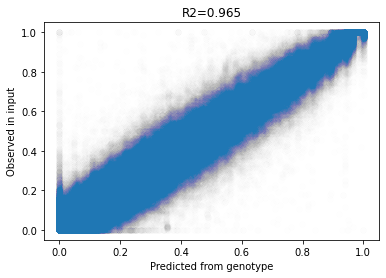

Joining genotype+input with IP allelic counts


In [25]:
merged = {} 
dat_sub = {}
for rep_index in range(len(input_counts)):
    merged[rep_index],dat_sub[rep_index] = deconvolve.merge_geno_and_counts(sanger, 
                                                                            input_counts[rep_index], 
                                                                            IP_counts[rep_index], 
                                                                            w[rep_index], 
                                                                            plot = True)

# Run beta models

Learned hyperparameters: {'input_conc': 78.20783233642578, 'input_count_conc': 279.3153381347656, 'IP_conc': 75.56892395019531, 'IP_count_conc': 458.8498840332031}


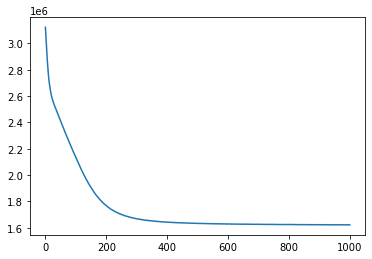

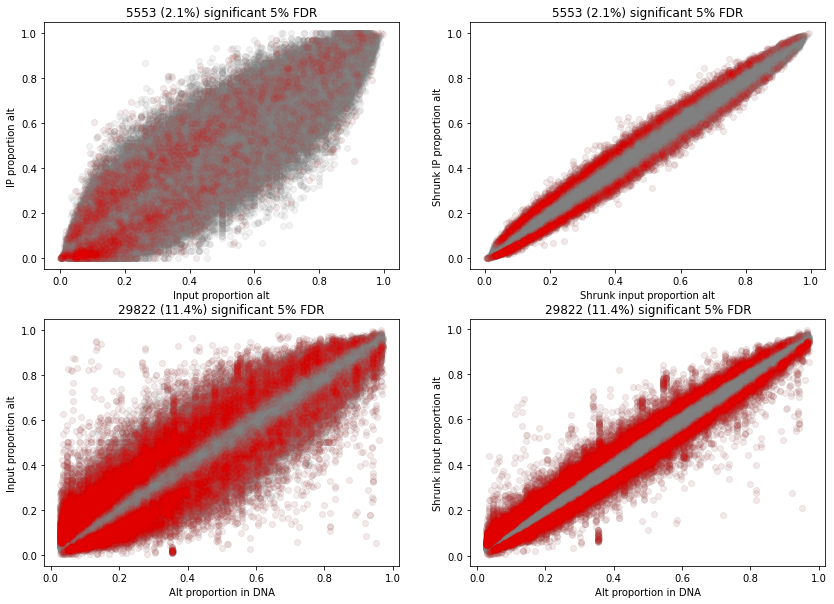

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input,altCount_input,totalCount_input,input_ratio,...,totalCount_IP,IP_ratio,shrunk_input_logratio,ase_loc,ase_sd,ase_q,shrunk_IP_logratio,asb_loc,asb_sd,asb_q
0,chr10,294953,rs1017361,A,G,249013,18,109,127,0.858268,...,233,0.944206,2.217722,-0.295365,0.211430,0.081209,2.581102,0.363381,0.339868,0.142494
1,chr10,320954,rs10903832,A,G,275014,98,24,122,0.196721,...,201,0.218905,-1.379707,0.063327,0.193570,0.371776,-1.320950,0.058757,0.340416,0.431481
2,chr10,323034,rs17158753,G,A,277094,71,7,78,0.089744,...,83,0.204819,-2.064728,0.051884,0.226532,0.409420,-1.672308,0.392419,0.241237,0.051901
3,chr10,323283,rs3740304,A,G,277343,60,52,112,0.464286,...,74,0.702703,0.248630,-0.167028,0.135709,0.109203,0.498460,0.249830,0.199662,0.105418
4,chr10,326894,rs3125027,T,C,280954,20,6,26,0.230769,...,36,0.277778,-1.211635,0.298241,0.207483,0.075299,-1.350553,-0.138918,0.334276,0.338859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261541,chr9,140995342,rs112278050,C,T,138100890,34,4,38,0.105263,...,37,0.027027,-2.926193,0.366768,0.383999,0.169757,-3.177074,-0.250881,0.523417,0.315858
261542,chr9,141003534,rs9410071,G,A,138109082,17,15,32,0.468750,...,41,0.512195,0.219482,-0.243013,0.165966,0.071566,0.264471,0.044989,0.208937,0.414757
261543,chr9,141005772,rs766373,A,G,138111320,16,27,43,0.627907,...,40,0.600000,0.529351,-0.076912,0.231134,0.369659,0.426541,-0.102810,0.192120,0.296278
261544,chr9,141005820,rs766375,C,T,138111368,28,11,39,0.282051,...,45,0.200000,-1.069229,0.006823,0.181701,0.485023,-1.217908,-0.148679,0.208110,0.237483


In [26]:
results = [ beta_model.fit_and_save(dat_sub[rep_index], 
                                             results_dir / ("beta" 
                                                            + ("_struct" if use_structured_guide else "") 
                                                            + ("_rep%i.tsv.gz" % rep_index)),
                                             use_structured_guide = True,
                                             iterations = 1000,
                                             device = device) for rep_index in range(len(merged)) ]

In [ ]:
for rep_index in range(len(merged)):
    beta_model.make_plots(results[rep_index], fdr_threshold)

For the beta model we model the two ratios (input and IP) separately but allow posterior dependence through the structured guide. For the Gaussian model we model the ASE effect (difference between DNA and RNA logit ratio) and ASB effect (difference between RNA and IP logit ratio). 

# Gaussian model without replicates

Could also run this with the mean field guide. 

Learned hyperparameters: {'ase_scale': 0.17810791730880737, 'input_count_conc': 184.60464477539062, 'asb_scale': 0.19789725542068481, 'IP_count_conc': 171.7748260498047, 'ase_t_df': 3.684199571609497, 'asb_t_df': 8.581000328063965}


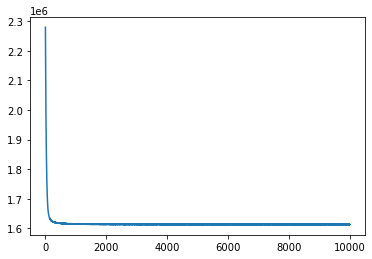

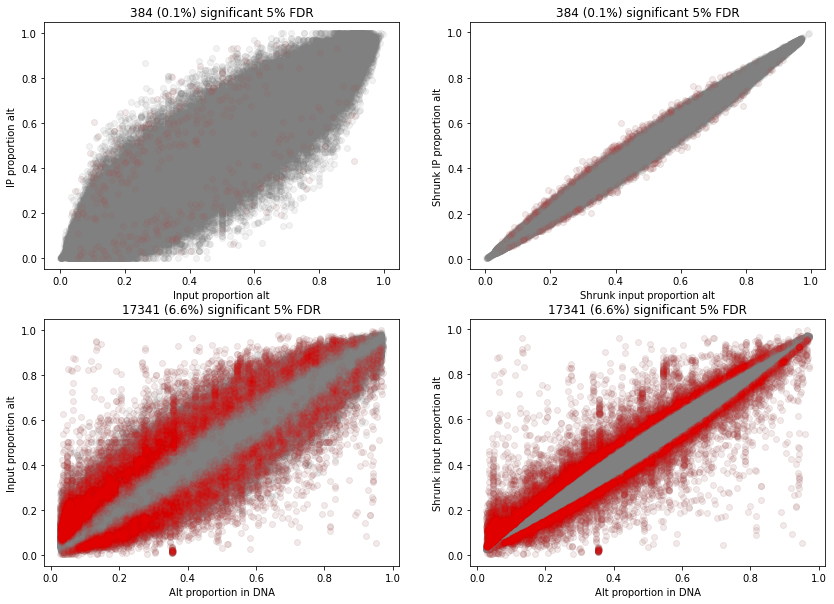

In [28]:
results = [ gaussian_model.fit_and_save(dat_sub[rep_index], 
                                             results_dir / ("normal" 
                                                            + ("_struct" if use_structured_guide else "") 
                                                            + ("_rep%i.tsv.gz" % rep_index)),
                                             use_structured_guide = True,
                                             iterations = 1000,
                                             device = device) for rep_index in range(len(merged)) ]

In [ ]:
for rep_index in range(len(merged)):
    beta_model.make_plots(results[rep_index], fdr_threshold)